In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
import scipy
import time
import gc
from sys import getsizeof
from scipy.signal import hilbert, hann, convolve
from scipy.ndimage.filters import convolve1d
from scipy import stats
from sklearn.kernel_ridge import KernelRidge

In [2]:
# train = pd.read_csv("../input/train.csv", dtype={'acoustic_data': np.int16})
train = pd.read_pickle('../input/train.pkl')

In [3]:
train.columns = ['signal','ttq']

In [5]:
train['ttq'] = train.ttq.astype(np.float16)

In [6]:
train.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629145480 entries, 0 to 629145479
Data columns (total 2 columns):
signal    int16
ttq       float16
dtypes: float16(1), int16(1)
memory usage: 2.3 GB


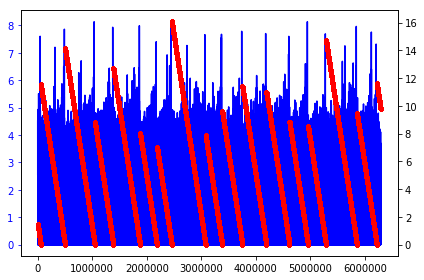

In [7]:
fig, ax1 = plt.subplots()
sig = np.abs(train.signal.values[::100])+1
sig=np.log(sig)
ax1.plot(sig, 'b-')
# Make the y-axis label, ticks and tick labels match the line color.
# ax1.set_yscale('log')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
ax2.plot(train.ttq.values[::100], 'r.')

fig.tight_layout()
plt.show()

(array([7.44260000e+04, 1.68250000e+05, 4.65157000e+05, 1.84412800e+06,
        5.15479530e+07, 5.68223199e+08, 5.26606300e+06, 8.70130000e+05,
        2.76218000e+05, 1.18204000e+05]),
 array([-100.,  -80.,  -60.,  -40.,  -20.,    0.,   20.,   40.,   60.,
          80.,  100.]),
 <a list of 10 Patch objects>)

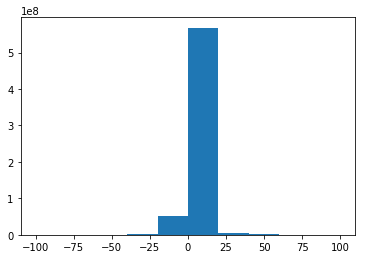

In [8]:
plt.hist(train.signal, range=[-100,100])

In [9]:
train.shape

(629145480, 2)

In [10]:
# np.save("../input/x_mat.npy", x_mat)
# np.save("../input/y_train.npy", y_train)
# np.save("../input/y_val.npy", y_val)

In [11]:
gc.collect()

12

In [12]:
n_samples=20000

In [13]:
x_mat = np.load("../input/x_mat.npy")
y_train = np.load("../input/y_train.npy")
y_val = np.load("../input/y_val.npy")

In [14]:
x_mat.shape

(24624, 150000)

In [15]:
getsizeof(x_mat)/1000000

7387.200112

In [16]:
n = x_mat.shape[0]

In [17]:
import threading

def gen():
    print('generator initiated')
    idx = 0
    while True:
        yield x_train[:100], y_train[:100]
        print('generator yielded a batch %d' % idx)
        idx += 1
        
tr_gen = gen()

In [18]:
yt=y_train.copy()

In [19]:
# x_train = x[:10000,:,:]
# x_val = x[n_samples:n_samples+n_vals,:,:]

In [20]:
y_train=yt[:20000,:]

In [21]:
y_train.shape

(20000, 1)

In [22]:
def rolling_window(a, window):
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

In [23]:
# a = np.array([[1,2,3,4,5,6,7,8,100,10], [1,4,7,2,5,8,3,6,9,2]])
a = np.array([1,2,5,5,5,6,7,5,5,5])
rolling_window(a,5).std(axis=1)
# print(pd.DataFrame(a).rolling(5).std().dropna().values.transpose())

array([1.74355958, 1.356466  , 0.8       , 0.8       , 0.8       ,
       0.8       ])

In [24]:
np.nonzero((np.diff(a) / a[:-1]))[0]

array([0, 1, 4, 5, 6], dtype=int64)

In [25]:
np.nonzero((np.diff(a) / a[:-1]))[0]

array([0, 1, 4, 5, 6], dtype=int64)

In [26]:
a = np.array([[1,2,3,4,5,6,7,8,100,10], [1,4,7,2,5,8,3,6,9,2], [1,4,4,4,4,8,3,6,9,2]])
# a = np.array([1,2,3,4,5,6,7,8,100,10])
b = rolling_window(a,5).std(axis=2).mean(axis=1)
# print(pd.DataFrame(a).rolling(5).std().dropna().values.transpose())
b

array([13.33232099,  2.25827497,  1.89006686])

In [27]:
nonzeros = np.zeros([3])
for i in range(3):
    nonzeros[i] = np.mean(np.nonzero(np.diff(a[i,:])/a[i,:-1])[0])

In [28]:
x_feat = np.zeros([n, 57], dtype=np.float16)

In [29]:
start = time.time()

x_feat[:,0] = x_mat.mean(axis=1)
x_feat[:,1] = x_mat.std(axis=1)
x_feat[:,2] = x_mat.max(axis=1)
x_feat[:,3] = x_mat.min(axis=1)
print(time.time()-start)

x_feat[:,4] = np.diff(x_mat, axis=1).mean(axis=1)
print(time.time()-start)

nonzeros = np.zeros(n, dtype=np.float16)
for i in range(n):
    nonzeros[i] = np.mean(np.nonzero(np.diff(x_mat[i,:])/x_mat[i,:-1])[0])
x_feat[:,5] = nonzeros
print(time.time()-start)

x_feat[:,6] = np.abs(x_mat).max(axis=1)
x_feat[:,7] = np.abs(x_mat).min(axis=1)

x_feat[:,8] = x_mat[:,:50000].std(axis=1)
x_feat[:,9] = x_mat[:,:-50000].std(axis=1)
x_feat[:,10] = x_mat[:,:10000].std(axis=1)
x_feat[:,11] = x_mat[:,:-10000].std(axis=1)
print(time.time()-start)

x_feat[:,9] = x_mat[:,:50000].mean(axis=1)
x_feat[:,10] = x_mat[:,:-50000].mean(axis=1)
x_feat[:,11] = x_mat[:,:10000].mean(axis=1)
x_feat[:,12] = x_mat[:,:-10000].mean(axis=1)
print(time.time()-start)

x_feat[:,13] = x_mat[:,:50000].min(axis=1)
x_feat[:,14] = x_mat[:,:-50000].min(axis=1)
x_feat[:,15] = x_mat[:,:10000].min(axis=1)
x_feat[:,16] = x_mat[:,:-10000].min(axis=1)
print(time.time()-start)

x_feat[:,17] = x_mat[:,:50000].max(axis=1)
x_feat[:,18] = x_mat[:,:-50000].max(axis=1)
x_feat[:,19] = x_mat[:,:10000].max(axis=1)
x_feat[:,20] = x_mat[:,:-10000].max(axis=1)
print(time.time()-start)

x_feat[:,21] = x_mat.max(axis=1)/np.abs(x_mat.min(axis=1))
x_feat[:,22] = x_mat.max(axis=1) - np.abs(x_mat.min(axis=1))
x_feat[:,23] = np.sum(np.abs(x_mat)>= 500, axis=1)
x_feat[:,24] = np.sum(np.abs(x_mat)>= 1000, axis=1)
print(time.time()-start)

x_feat[:,25] = np.quantile(np.abs(x_mat), 0.95, axis=1)
x_feat[:,26] = np.quantile(np.abs(x_mat), 0.05, axis=1)
x_feat[:,27] = np.quantile(np.abs(x_mat), 0.99, axis=1)
x_feat[:,28] = np.quantile(np.abs(x_mat), 0.01, axis=1)
print(time.time()-start)

x_feat[:,29] = np.quantile(x_mat, 0.95, axis=1)
x_feat[:,30] = np.quantile(x_mat, 0.05, axis=1)
x_feat[:,31] = np.quantile(x_mat, 0.99, axis=1)
x_feat[:,32] = np.quantile(x_mat, 0.01, axis=1)
print(time.time()-start)

x_feat[:,33] = np.abs(x_mat).mean(axis=1)
x_feat[:,34] = stats.kurtosis(x_mat, axis=1)
x_feat[:,35] = stats.skew(x_mat, axis=1)
x_feat[:,36] = np.median(x_mat, axis=1)
print(time.time()-start)

x_feat[:,37] = np.abs(hilbert(x_mat)).mean(axis=1)
x_feat[:,38] = convolve1d(x_mat, hann(150), mode="constant").mean(axis=1)
x_feat[:,39] = np.sum(np.abs(x_mat)>= 250, axis=1)
x_feat[:,40] = np.sum(np.abs(x_mat)>= 100, axis=1)
print(time.time()-start)
print('Begin Rolling')

j=40

for version in ['std', 'mean']:
    for window in [10,100,1000]:
        if version == 'std':
            x_roll = x.rolling_window(x_mat, window).std(axis=2)
        if version == 'mean':
            x_roll = x.rolling_window(x_mat, window).mean(axis=2)

        x_feat[:, j+1] = x_roll.mean(axis=1)
        x_feat[:, j+2] = x_roll.std(axis=1)
        x_feat[:, j+3] = x_roll.max(axis=1)
        x_feat[:, j+4] = x_roll.min(axis=1)
        j = j+4

        x_feat[:, j+1] = np.quantile(x_roll, 0.01, axis=1)
        x_feat[:, j+2] = np.quantile(x_roll, 0.99, axis=1)
        x_feat[:, j+3] = np.quantile(x_roll, 0.05, axis=1)
        x_feat[:, j+4] = np.quantile(x_roll, 0.95, axis=1)
        j=j+4
        print(time.time()-start)

56.128148794174194
72.14348125457764


c:\users\jsab\anaconda3\envs\mlenv\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in true_divide
  
c:\users\jsab\anaconda3\envs\mlenv\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


168.20471286773682
284.0879793167114
294.7218885421753
302.05437898635864
309.3798713684082
364.1346597671509
1143.2824532985687
1891.4256114959717
2814.004231929779


error: (n>0&&n<=size(x)) failed for 1st keyword n: zrfft:n=150000

In [30]:
gc.collect()

0

In [88]:
import numba
from numba import jit, guvectorize
from numba import cuda

In [92]:
@cuda.jit
def nb_sort(x):
    return np.sort(x, axis=1)

In [93]:
%%time
nb_sort(x_mat[0:10000,:])

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1m[1m[1mInvalid use of BoundFunction(array.sort for array(int16, 2d, C)) with parameters ()
 * parameterized[0m
[0m[1m[1] During: resolving callee type: BoundFunction(array.sort for array(int16, 2d, C))[0m
[0m[1m[2] During: typing of call at <ipython-input-92-a712befc6ff8> (3)
[0m
[1m
File "<ipython-input-92-a712befc6ff8>", line 3:[0m
[1mdef nb_sort(x):
[1m    return x.sort()
[0m    [1m^[0m[0m


In [85]:
%%time
np.sort(x_mat[0:1000,:])

Wall time: 3.89 s


array([[-113, -112, -111, ...,  132,  136,  136],
       [ -92,  -86,  -85, ...,  106,  106,  111],
       [-181, -175, -162, ...,  211,  214,  215],
       ...,
       [-185, -185, -180, ...,  179,  188,  193],
       [-115, -112, -100, ...,  105,  106,  110],
       [ -85,  -82,  -78, ...,  101,  101,  105]], dtype=int16)

In [47]:
%%time
np.quantile(x_mat[:1000,:], 0.95, axis=1)

Wall time: 5.43 s


array([11.  , 11.  , 12.  , 12.  , 13.  , 11.  , 10.  ,  9.  , 12.  ,
        9.  , 12.  , 10.  , 10.  , 12.  , 10.  , 10.  , 11.  , 11.  ,
       12.  , 11.  , 10.  , 10.  , 12.  , 12.  , 12.  , 11.  , 12.  ,
       11.  , 10.  , 13.  , 10.  , 11.  , 12.  , 11.  , 12.  ,  9.  ,
        9.  , 12.  , 11.  , 10.  , 10.  , 11.  , 12.  , 12.  , 11.  ,
       12.  , 10.  , 11.  , 12.  , 10.  , 13.  , 12.  , 12.  , 10.  ,
        9.  , 12.  , 11.  , 11.  , 10.  , 10.  , 10.  , 12.  , 11.  ,
       11.  , 10.  , 10.  , 10.  , 10.  , 10.  , 15.  , 11.  , 10.  ,
       11.  , 10.  , 12.  , 10.  , 12.  , 12.  , 10.  , 12.  , 10.  ,
       10.  , 10.  , 10.  , 12.  , 10.  , 11.  , 10.  , 12.  , 11.  ,
       12.  , 10.  , 12.  , 11.  ,  9.  , 12.  , 11.  , 10.  ,  9.  ,
       11.  , 13.  , 13.  , 12.  , 12.  , 13.  ,  9.  , 12.  , 11.  ,
       11.  , 12.  , 12.  , 10.  , 10.  , 13.  , 10.  ,  9.  , 12.  ,
        9.  , 10.  , 11.  , 12.  , 10.  , 14.  , 12.  ,  9.  , 10.  ,
       10.  , 14.  ,

In [41]:
%%time
np.abs(hilbert(x_mat[0:1000,:])).mean(axis=1)

Wall time: 18 s


array([ 7.03305804,  6.74145629,  7.9775095 ,  8.33338103,  7.95542766,
        7.01956221,  6.10815285,  5.7882232 ,  6.98702133,  5.54646962,
        7.59498721,  6.20991377,  5.96771685,  7.58268163,  5.99605696,
        6.17796847,  6.95722954,  7.15438777,  7.57267104,  7.323966  ,
        6.29331493,  6.11165434,  8.0514689 ,  7.75072485,  7.85893198,
        6.9367802 ,  7.53475357,  6.67851071,  6.48103157,  7.923745  ,
        5.98011156,  6.95906275,  7.8512384 ,  6.64754081,  7.21616592,
        5.94023248,  5.64202102,  8.81141327,  6.85573738,  6.51716399,
        6.33897162,  6.88762388,  7.39329658,  7.57301635,  7.20732206,
        7.37848736,  6.03317381,  7.09375817,  7.35677025,  6.29642871,
        8.34568266,  7.33719867,  7.95807203,  6.56941082,  5.76332312,
        7.65611803,  6.70149815,  6.91830378,  6.72383196,  5.935185  ,
        6.13027949,  7.7267737 ,  6.78121743,  6.96881852,  6.28851263,
        5.87123762,  6.16340922,  5.93008188,  6.5982806 ,  9.72

In [155]:
x_feat[:,37] = np.abs(hilbert(x_mat)).mean(axis=1)

MemoryError: 

In [138]:
a = np.array([[1,2,3,4,5,6,7], [1,2,3,4,5,9,7]])
b = np.array([1,2,3,4,5,6,7])
# b.rolling(3)

In [107]:
convolve(b, hann(7), mode="same")

array([ 3.25,  6.  ,  9.  , 12.  , 15.  , 16.  , 12.75])

In [50]:
def rolling_window(a, window):
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

In [37]:
%%time
np.diff(x_mat, axis=1).mean(axis=1).shape

Wall time: 13.8 s


(24624,)

In [32]:
x_mat.mean(axis=1).shape

(24624,)

In [26]:
getsizeof(x_train)/1000000

0.800112

C:\Users\jsab\Anaconda3\lib\site-packages\numpy\core\numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


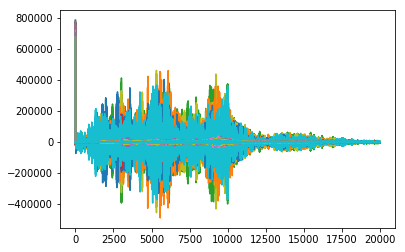

In [39]:
for i in range(1000):
    plt.plot(np.fft.fft(x_mat[i,:])[:20000])

In [40]:
%%time
xlog=np.zeros(shape=x_mat.shape)
for i in range(x_mat.shape[0]):
    xlog[i, :] = np.log(np.abs(np.fft.fft(x_mat[i,:]).real))

Wall time: 3min 9s


In [11]:
xlog.shape

(24624, 150000)

In [54]:
xl = xlog.copy()

In [63]:
n=xl.shape[0]

In [298]:
x_log = xl[:,1:20001].reshape([n,1000,20])

In [299]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
dev_scaler = StandardScaler()
def dev_scale(x): 
    return dev_scaler.fit_transform(x)

In [300]:
# %%time
x = np.zeros([n, 1000, 5], dtype=np.float16)
x[:,:,0] = np.mean(x_log,axis=2)
x[:,:,1] = np.median(x_log,axis=2)
x[:,:,2] = np.max(x_log,axis=2)
x[:,:,3] = np.min(x_log,axis=2)
x[:,:,4] = np.std(x_log,axis=2)

In [317]:
x=x.reshape([n,1000,5])

In [318]:
# xi = x[:,:,2]
xi=x

In [319]:
x_train=xi[:20000,:]
y_train = yt[:20000,:]
x_val=xi[20000:22000,:]

In [320]:
xi.shape

(24624, 1000, 5)

In [321]:
xi

array([[[ 7.414 ,  7.664 ,  8.664 ,  5.566 ,  0.7964],
        [ 6.555 ,  6.617 ,  8.38  ,  3.338 ,  1.226 ],
        [ 6.83  ,  7.133 ,  7.938 ,  4.473 ,  0.8853],
        ...,
        [ 5.86  ,  5.836 ,  7.53  ,  3.46  ,  1.005 ],
        [ 6.164 ,  6.44  ,  7.527 ,  4.402 ,  0.9116],
        [ 5.93  ,  6.43  ,  7.652 ,  1.895 ,  1.608 ]],

       [[ 7.06  ,  6.89  ,  9.02  ,  5.285 ,  1.065 ],
        [ 6.586 ,  6.547 ,  8.05  ,  3.133 ,  1.041 ],
        [ 6.51  ,  6.83  ,  7.902 ,  3.207 ,  1.288 ],
        ...,
        [ 6.51  ,  6.566 ,  7.594 ,  4.633 ,  0.805 ],
        [ 5.93  ,  6.32  ,  7.598 ,  4.062 ,  1.156 ],
        [ 6.035 ,  6.35  ,  7.293 ,  2.578 ,  1.117 ]],

       [[ 7.387 ,  7.68  ,  8.36  ,  5.234 ,  0.893 ],
        [ 7.13  ,  7.383 ,  8.1   ,  5.24  ,  0.756 ],
        [ 6.594 ,  6.594 ,  7.78  ,  5.04  ,  0.729 ],
        ...,
        [ 6.176 ,  6.51  ,  7.367 ,  4.125 ,  0.851 ],
        [ 6.297 ,  6.547 ,  7.418 ,  4.32  ,  0.8345],
        [ 6.254 ,  6.7

In [316]:
import tensorflow
from keras.models import Sequential, Model
from keras.optimizers import SGD, Adam
from keras.layers import Dense, Conv1D, Conv2D, Flatten, Dropout, Input, Bidirectional

inputs = Input(shape=x_train.shape[1:])
X = Dense(2)(inputs)
# X = Dropout(0.25)(X)
predictions = Dense(1)(X)

model = Model(inputs=inputs, outputs=predictions)
print(model.summary())
model.compile(loss='mean_squared_error', optimizer=SGD(lr=0.00001, decay=1e-6), metrics=['mae','mean_squared_error'])
model.fit(x_train, y_train, epochs=10000, batch_size=2500, verbose=1, validation_data=(x_val, y_val))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_63 (InputLayer)        (None, 1000)              0         
_________________________________________________________________
dense_186 (Dense)            (None, 2)                 2002      
_________________________________________________________________
dense_187 (Dense)            (None, 1)                 3         
Total params: 2,005
Trainable params: 2,005
Non-trainable params: 0
_________________________________________________________________
None
Train on 20000 samples, validate on 2000 samples
Epoch 1/10000
20000/20000 [==============================] - 4s 179us/step - loss: 17.8050 - mean_absolute_error: 3.4140 - mean_squared_error: 17.8050 - val_loss: 16.9013 - val_mean_absolute_error: 3.4324 - val_mean_squared_error: 16.9013
Epoch 2/10000
20000/20000 [==============================] - 0s 13us/step - loss: 14.0238 - mean_absolute_error

20000/20000 [==============================] - 0s 13us/step - loss: 13.1649 - mean_absolute_error: 2.9865 - mean_squared_error: 13.1649 - val_loss: 15.9441 - val_mean_absolute_error: 3.3324 - val_mean_squared_error: 15.9441
Epoch 33/10000
20000/20000 [==============================] - 0s 13us/step - loss: 13.1583 - mean_absolute_error: 2.9865 - mean_squared_error: 13.1583 - val_loss: 15.9271 - val_mean_absolute_error: 3.3280 - val_mean_squared_error: 15.9271
Epoch 34/10000
20000/20000 [==============================] - 0s 13us/step - loss: 13.1099 - mean_absolute_error: 2.9809 - mean_squared_error: 13.1099 - val_loss: 16.0204 - val_mean_absolute_error: 3.3165 - val_mean_squared_error: 16.0204
Epoch 35/10000
20000/20000 [==============================] - 0s 13us/step - loss: 13.0798 - mean_absolute_error: 2.9755 - mean_squared_error: 13.0798 - val_loss: 15.9466 - val_mean_absolute_error: 3.3156 - val_mean_squared_error: 15.9466
Epoch 36/10000
20000/20000 [==============================]

20000/20000 [==============================] - 0s 13us/step - loss: 11.6912 - mean_absolute_error: 2.7886 - mean_squared_error: 11.6912 - val_loss: 14.4421 - val_mean_absolute_error: 3.1427 - val_mean_squared_error: 14.4421
Epoch 101/10000
20000/20000 [==============================] - 0s 13us/step - loss: 11.6673 - mean_absolute_error: 2.7843 - mean_squared_error: 11.6673 - val_loss: 14.4192 - val_mean_absolute_error: 3.1407 - val_mean_squared_error: 14.4192
Epoch 102/10000
20000/20000 [==============================] - 0s 13us/step - loss: 11.6494 - mean_absolute_error: 2.7829 - mean_squared_error: 11.6494 - val_loss: 14.5214 - val_mean_absolute_error: 3.1317 - val_mean_squared_error: 14.5214
Epoch 103/10000
20000/20000 [==============================] - 0s 13us/step - loss: 11.6411 - mean_absolute_error: 2.7797 - mean_squared_error: 11.6411 - val_loss: 14.4795 - val_mean_absolute_error: 3.1302 - val_mean_squared_error: 14.4795
Epoch 104/10000
20000/20000 [===========================

20000/20000 [==============================] - 0s 13us/step - loss: 10.6944 - mean_absolute_error: 2.6406 - mean_squared_error: 10.6944 - val_loss: 13.3741 - val_mean_absolute_error: 3.0000 - val_mean_squared_error: 13.3741
Epoch 169/10000
20000/20000 [==============================] - 0s 13us/step - loss: 10.6728 - mean_absolute_error: 2.6362 - mean_squared_error: 10.6728 - val_loss: 13.3302 - val_mean_absolute_error: 3.0010 - val_mean_squared_error: 13.3302
Epoch 170/10000
20000/20000 [==============================] - 0s 13us/step - loss: 10.6586 - mean_absolute_error: 2.6343 - mean_squared_error: 10.6586 - val_loss: 13.2852 - val_mean_absolute_error: 3.0031 - val_mean_squared_error: 13.2852
Epoch 171/10000
20000/20000 [==============================] - 0s 13us/step - loss: 10.6556 - mean_absolute_error: 2.6357 - mean_squared_error: 10.6556 - val_loss: 13.4711 - val_mean_absolute_error: 2.9885 - val_mean_squared_error: 13.4711
Epoch 172/10000
20000/20000 [===========================

20000/20000 [==============================] - 0s 13us/step - loss: 10.0127 - mean_absolute_error: 2.5328 - mean_squared_error: 10.0127 - val_loss: 12.5637 - val_mean_absolute_error: 2.9000 - val_mean_squared_error: 12.5637
Epoch 237/10000
20000/20000 [==============================] - 0s 13us/step - loss: 10.0087 - mean_absolute_error: 2.5319 - mean_squared_error: 10.0087 - val_loss: 12.5930 - val_mean_absolute_error: 2.8952 - val_mean_squared_error: 12.5930
Epoch 238/10000
20000/20000 [==============================] - 0s 13us/step - loss: 10.0104 - mean_absolute_error: 2.5307 - mean_squared_error: 10.0104 - val_loss: 12.4530 - val_mean_absolute_error: 2.9208 - val_mean_squared_error: 12.4530
Epoch 239/10000
20000/20000 [==============================] - 0s 13us/step - loss: 9.9951 - mean_absolute_error: 2.5314 - mean_squared_error: 9.9951 - val_loss: 12.5065 - val_mean_absolute_error: 2.9004 - val_mean_squared_error: 12.5065
Epoch 240/10000
20000/20000 [=============================

20000/20000 [==============================] - 0s 13us/step - loss: 9.5670 - mean_absolute_error: 2.4588 - mean_squared_error: 9.5670 - val_loss: 12.0212 - val_mean_absolute_error: 2.8300 - val_mean_squared_error: 12.0212
Epoch 305/10000
20000/20000 [==============================] - 0s 13us/step - loss: 9.5622 - mean_absolute_error: 2.4609 - mean_squared_error: 9.5622 - val_loss: 12.1352 - val_mean_absolute_error: 2.8194 - val_mean_squared_error: 12.1352
Epoch 306/10000
20000/20000 [==============================] - 0s 13us/step - loss: 9.5559 - mean_absolute_error: 2.4570 - mean_squared_error: 9.5559 - val_loss: 12.0214 - val_mean_absolute_error: 2.8265 - val_mean_squared_error: 12.0214
Epoch 307/10000
20000/20000 [==============================] - 0s 13us/step - loss: 9.5615 - mean_absolute_error: 2.4597 - mean_squared_error: 9.5615 - val_loss: 12.0992 - val_mean_absolute_error: 2.8187 - val_mean_squared_error: 12.0992
Epoch 308/10000
20000/20000 [==============================] - 0

20000/20000 [==============================] - 0s 13us/step - loss: 9.2867 - mean_absolute_error: 2.4125 - mean_squared_error: 9.2867 - val_loss: 11.8381 - val_mean_absolute_error: 2.7711 - val_mean_squared_error: 11.8381
Epoch 373/10000
20000/20000 [==============================] - 0s 13us/step - loss: 9.2898 - mean_absolute_error: 2.4119 - mean_squared_error: 9.2898 - val_loss: 11.7829 - val_mean_absolute_error: 2.7716 - val_mean_squared_error: 11.7829
Epoch 374/10000
20000/20000 [==============================] - 0s 13us/step - loss: 9.2663 - mean_absolute_error: 2.4067 - mean_squared_error: 9.2663 - val_loss: 11.6159 - val_mean_absolute_error: 2.7886 - val_mean_squared_error: 11.6159
Epoch 375/10000
20000/20000 [==============================] - 0s 13us/step - loss: 9.2892 - mean_absolute_error: 2.4154 - mean_squared_error: 9.2892 - val_loss: 11.7594 - val_mean_absolute_error: 2.7711 - val_mean_squared_error: 11.7594
Epoch 376/10000
20000/20000 [==============================] - 0

20000/20000 [==============================] - 0s 13us/step - loss: 9.0918 - mean_absolute_error: 2.3774 - mean_squared_error: 9.0918 - val_loss: 11.4041 - val_mean_absolute_error: 2.7535 - val_mean_squared_error: 11.4041
Epoch 441/10000
20000/20000 [==============================] - 0s 13us/step - loss: 9.1035 - mean_absolute_error: 2.3822 - mean_squared_error: 9.1035 - val_loss: 11.5667 - val_mean_absolute_error: 2.7401 - val_mean_squared_error: 11.5667
Epoch 442/10000
20000/20000 [==============================] - 0s 13us/step - loss: 9.0786 - mean_absolute_error: 2.3760 - mean_squared_error: 9.0786 - val_loss: 11.5791 - val_mean_absolute_error: 2.7393 - val_mean_squared_error: 11.5791
Epoch 443/10000
20000/20000 [==============================] - 0s 13us/step - loss: 9.0794 - mean_absolute_error: 2.3750 - mean_squared_error: 9.0794 - val_loss: 11.4773 - val_mean_absolute_error: 2.7431 - val_mean_squared_error: 11.4773
Epoch 444/10000
20000/20000 [==============================] - 0

20000/20000 [==============================] - 0s 13us/step - loss: 8.9647 - mean_absolute_error: 2.3527 - mean_squared_error: 8.9647 - val_loss: 11.2300 - val_mean_absolute_error: 2.7350 - val_mean_squared_error: 11.2300
Epoch 509/10000
20000/20000 [==============================] - 0s 13us/step - loss: 8.9622 - mean_absolute_error: 2.3565 - mean_squared_error: 8.9622 - val_loss: 11.3079 - val_mean_absolute_error: 2.7236 - val_mean_squared_error: 11.3079
Epoch 510/10000
20000/20000 [==============================] - 0s 13us/step - loss: 8.9522 - mean_absolute_error: 2.3536 - mean_squared_error: 8.9522 - val_loss: 11.2877 - val_mean_absolute_error: 2.7249 - val_mean_squared_error: 11.2877
Epoch 511/10000
20000/20000 [==============================] - 0s 13us/step - loss: 8.9749 - mean_absolute_error: 2.3571 - mean_squared_error: 8.9749 - val_loss: 11.3696 - val_mean_absolute_error: 2.7195 - val_mean_squared_error: 11.3696
Epoch 512/10000
20000/20000 [==============================] - 0

20000/20000 [==============================] - 0s 13us/step - loss: 8.8965 - mean_absolute_error: 2.3449 - mean_squared_error: 8.8965 - val_loss: 11.2985 - val_mean_absolute_error: 2.7043 - val_mean_squared_error: 11.2985
Epoch 577/10000
20000/20000 [==============================] - 0s 13us/step - loss: 8.8697 - mean_absolute_error: 2.3364 - mean_squared_error: 8.8697 - val_loss: 11.1442 - val_mean_absolute_error: 2.7149 - val_mean_squared_error: 11.1442
Epoch 578/10000
20000/20000 [==============================] - 0s 13us/step - loss: 8.8761 - mean_absolute_error: 2.3402 - mean_squared_error: 8.8761 - val_loss: 11.1741 - val_mean_absolute_error: 2.7108 - val_mean_squared_error: 11.1741
Epoch 579/10000
20000/20000 [==============================] - 0s 13us/step - loss: 8.8761 - mean_absolute_error: 2.3387 - mean_squared_error: 8.8761 - val_loss: 11.1633 - val_mean_absolute_error: 2.7116 - val_mean_squared_error: 11.1633
Epoch 580/10000
20000/20000 [==============================] - 0

20000/20000 [==============================] - 0s 13us/step - loss: 8.8409 - mean_absolute_error: 2.3350 - mean_squared_error: 8.8409 - val_loss: 11.3509 - val_mean_absolute_error: 2.6937 - val_mean_squared_error: 11.3509
Epoch 645/10000
20000/20000 [==============================] - 0s 13us/step - loss: 8.8290 - mean_absolute_error: 2.3289 - mean_squared_error: 8.8290 - val_loss: 11.2256 - val_mean_absolute_error: 2.6941 - val_mean_squared_error: 11.2256
Epoch 646/10000
20000/20000 [==============================] - 0s 13us/step - loss: 8.8176 - mean_absolute_error: 2.3271 - mean_squared_error: 8.8176 - val_loss: 11.0453 - val_mean_absolute_error: 2.7079 - val_mean_squared_error: 11.0453
Epoch 647/10000
20000/20000 [==============================] - 0s 13us/step - loss: 8.8103 - mean_absolute_error: 2.3285 - mean_squared_error: 8.8103 - val_loss: 11.0807 - val_mean_absolute_error: 2.7019 - val_mean_squared_error: 11.0807
Epoch 648/10000
20000/20000 [==============================] - 0

KeyboardInterrupt: 

In [189]:
import tensorflow
from keras.models import Sequential, Model
from keras.optimizers import SGD
from keras.layers import Dense, Conv1D, Conv2D, Flatten, Dropout, Input, Bidirectional

inputs = Input(shape=x_train.shape[1:])
X = Bidirectional(LSTM(units=8, return_sequences=False))(inputs)
# X = Flatten(X)
predictions = Dense(1)(X)

model = Model(inputs=inputs, outputs=predictions)
print(model.summary())
model.compile(loss='mean_squared_error', optimizer=SGD(), metrics=['mae','mean_squared_error'])
model.fit(x_train, y_train, epochs=100, batch_size=250, verbose=1, validation_data=(x_val, y_val))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        (None, 800, 5)            0         
_________________________________________________________________
bidirectional_8 (Bidirection (None, 16)                896       
_________________________________________________________________
dense_30 (Dense)             (None, 1)                 17        
Total params: 913
Trainable params: 913
Non-trainable params: 0
_________________________________________________________________
None
Train on 20000 samples, validate on 2000 samples
Epoch 1/100
20000/20000 [==============================] - 284s 14ms/step - loss: 14.6835 - mean_absolute_error: 3.1077 - mean_squared_error: 14.6835 - val_loss: 15.8525 - val_mean_absolute_error: 3.3142 - val_mean_squared_error: 15.8525
Epoch 2/100
20000/20000 [==============================] - 280s 14ms/step - loss: 13.0936 - mean_absolute_error: 2.9

KeyboardInterrupt: 

In [322]:
import tensorflow
from keras.models import Sequential
from keras.optimizers import SGD
from keras.layers import Dense, Conv1D, Conv2D, Flatten, Dropout

#create model
model = Sequential()

#add model layers
model.add(Conv2D(16, kernel_size=(1,5), activation='relu', input_shape=(200,5,1)))
model.add(Flatten())
model.add(Conv1D(4, kernel_size=3, activation='relu'))
model.add(Dense(1, activation='relu'))
model.compile(loss='mean_squared_error', optimizer=SGD(), metrics=['mae','mean_squared_error'])
model.fit(x_train, y_train, epochs=100, batch_size=64, verbose=1, validation_data=(x_val, y_val))

ValueError: Input 0 is incompatible with layer conv1d_41: expected ndim=3, found ndim=2

In [326]:
import tensorflow
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional, Activation, CuDNNLSTM
from keras.optimizers import SGD
# create and fit the LSTM network
mod = Sequential()
mod.add(Bidirectional(CuDNNLSTM(units=24, return_sequences=True, input_shape=x_train.shape[1:])))
mod.add(CuDNNLSTM(units=2, return_sequences=False))
mod.add(Dense(1, activation='relu'))
mod.compile(loss='mean_squared_error', optimizer=SGD(), metrics=['mae','mean_squared_error'])
mod.fit(x_train, y_train, epochs=100, batch_size=500, verbose=1, validation_data=(x_val, y_val))

Train on 20000 samples, validate on 2000 samples
Epoch 1/100
20000/20000 [==============================] - 13s 632us/step - loss: 44.6518 - mean_absolute_error: 5.6182 - mean_squared_error: 44.6518 - val_loss: 51.4370 - val_mean_absolute_error: 5.9779 - val_mean_squared_error: 51.4370
Epoch 2/100
20000/20000 [==============================] - 8s 404us/step - loss: 44.6518 - mean_absolute_error: 5.6182 - mean_squared_error: 44.6518 - val_loss: 51.4370 - val_mean_absolute_error: 5.9779 - val_mean_squared_error: 51.4370
Epoch 3/100
20000/20000 [==============================] - 8s 401us/step - loss: 44.6518 - mean_absolute_error: 5.6182 - mean_squared_error: 44.6518 - val_loss: 51.4370 - val_mean_absolute_error: 5.9779 - val_mean_squared_error: 51.4370
Epoch 4/100
18500/20000 [==========================>...] - ETA: 0s - loss: 44.6194 - mean_absolute_error: 5.6105 - mean_squared_error: 44.6194

KeyboardInterrupt: 

In [35]:
model.predict(x)

array([[4.097053 ],
       [2.7425199],
       [2.9276323],
       ...,
       [3.5980787],
       [4.600548 ],
       [8.837812 ]], dtype=float32)

In [217]:
model.predict(x_train)

array([[4.9028196],
       [3.3967416],
       [3.6990693],
       ...,
       [5.9858127],
       [2.9790916],
       [7.1291265]], dtype=float32)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600


In [220]:
test_mat

array([[ 4.,  0., -2., ...,  6.,  9.,  8.],
       [ 5.,  8.,  8., ...,  2.,  1.,  3.],
       [ 8.,  2.,  3., ..., -1.,  2.,  5.],
       ...,
       [ 3.,  0.,  0., ...,  3.,  2.,  5.],
       [ 3., -3.,  3., ...,  1.,  1.,  3.],
       [ 6.,  5.,  5., ...,  2.,  1.,  3.]])

In [221]:
test_mat.shape

(2624, 150000)

In [222]:
test_mat[1, :].shape

(150000,)

In [79]:
x_test = np.zeros([len(files), n_obs, 4])
for i in range(len(files)):
    if i%500==0:
        print(i)
    for j in range(n_obs):
        x_test[i,j,0] = np.max(test_mat[i, j*step_size:(j+1)*step_size])
        x_test[i,j,1] = np.min(test_mat[i, j*step_size:(j+1)*step_size])
        x_test[i,j,2] = np.mean(test_mat[i, j*step_size:(j+1)*step_size])
        x_test[i,j,3] = np.std(test_mat[i, j*step_size:(j+1)*step_size])

0
500
1000
1500
2000
2500


In [224]:
x_test = np.zeros([len(files), int(size/step_size),5])
x_test[:, :, 0] = np.max(test_mat.reshape([2624,int(size/step_size),step_size]),axis=2)
x_test[:, :, 1] = np.min(test_mat.reshape([2624,int(size/step_size),step_size]),axis=2)
x_test[:, :, 2] = np.mean(test_mat.reshape([2624,int(size/step_size),step_size]),axis=2)
x_test[:, :, 3] = np.std(test_mat.reshape([2624,int(size/step_size),step_size]),axis=2)
x_test[:, :, 4] = scipy.stats.kurtosis(test_mat.reshape([2624,int(size/step_size),step_size]),axis=2)

In [81]:
x_test.shape

(2624, 100, 4)

In [225]:
preds = model.predict(x_test)[:,0]

In [226]:
preds

array([4.3751645, 6.6565156, 6.468862 , ..., 3.238063 , 2.5696244,
       9.150722 ], dtype=float32)

In [227]:
submission = pd.DataFrame({'seg_id': seq, 'time_to_failure': preds})

In [228]:
submission.to_csv('../output/submission_3.csv', index=False)